<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2  (Problem 2) - Character Generator Model (Individual)</h2><h3>AY2022/23 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages
from tensorflow import keras
print('keras: ', keras.__version__)

keras:  2.10.0


In [2]:
import re
import numpy as np
from keras.preprocessing.text import Tokenizer

## Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [3]:
# Load Harry Potter text data
text = open('Harry_Potter_Book2.txt', encoding='utf-8').read().lower()
print('Corpus length:', len(text))
print(type(text))

Corpus length: 531708
<class 'str'>


### 1.2 Data Processing


In [4]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    return phrase

text = text.replace("j.k. rowling", "")
text = decontracted(text)
text = re.sub("[()*%/:;\\|•\n]", "", text)

In [5]:
# Length of extracted character sequences
SEQUENCE_LENGTH = 60
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - SEQUENCE_LENGTH, step):
    sentences.append(text[i: i + SEQUENCE_LENGTH])
    next_chars.append(text[i + SEQUENCE_LENGTH])

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
print(chars)
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

Unique characters: 50
[' ', '!', '"', "'", ',', '-', '.', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '?', '\\', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '—', '‘', '’', '“', '”']


In [6]:
# One-hot encoding of X and y
x = np.zeros((len(sentences), SEQUENCE_LENGTH, len(chars)), dtype=bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool_)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

In [8]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas) #return to the selected "next character"

In [9]:
import sys
# Use the trained model to generate new text
def generate_text(model, SEQUENCE_LENGTH, generated_text, temperature=1.0):
    print('------ temperature:', temperature)
    sys.stdout.write(generated_text)
    log_probs = [] # Store the log-probabilities of the generated characters

    for i in range(400):
        x_pred = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
        for t, char in enumerate(generated_text):
            x_pred[0, t, char_indices[char]] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        log_probs.append(np.log(preds[next_index])) # Record the log-probability of the generated character
        generated_text += next_char
        generated_text = generated_text[1:]
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
        
    perplexity = np.exp(-np.sum(log_probs) / len(log_probs))
    print("\nPerplexity:", perplexity)
    print()

    return generated_text

In [10]:
def generate_text_based_on_input(model, SEQUENCE_LENGTH, input_text, temperature=1.0):
    print('------ temperature:', temperature)
    input_text = input_text[-SEQUENCE_LENGTH:]
    generated_text = " " * (SEQUENCE_LENGTH - len(input_text)) + input_text #Padding input text
    sys.stdout.write(input_text)
    log_probs = [] # Store the log-probabilities of the generated characters

    for i in range(400):
        x_pred = np.zeros((1, SEQUENCE_LENGTH, len(chars)))
        for t, char in enumerate(generated_text):
            x_pred[0, t, char_indices[char]] = 1

        preds = model.predict(x_pred, verbose=0)[0]
        next_index = sample(preds, temperature)
        next_char = chars[next_index]

        log_probs.append(np.log(preds[next_index])) # Record the log-probability of the generated character
        generated_text += next_char
        generated_text = generated_text[1:]
        
        sys.stdout.write(next_char)
        sys.stdout.flush()
        
    perplexity = np.exp(-np.sum(log_probs) / len(log_probs))
    print("\nPerplexity:", perplexity)
    print()

    return generated_text

## Step 2 – Develop Character Generator Model

### Model 1 - Baseline

In [12]:
# Define a model, compile and fit it using X and y
from keras.layers import Dense, Embedding, LSTM, SimpleRNN, GRU, Bidirectional, Dropout, Flatten
from tensorflow.keras import optimizers
from keras import regularizers
from keras.models import Sequential

model1 = Sequential()
model1.add(Embedding(len(chars), 32, input_shape=(SEQUENCE_LENGTH, len(chars))))
model1.add(Flatten())
model1.add(Dense(len(chars), activation='softmax'))

model1.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=['acc'])
history = model1.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
1062/1062 [==============================] - 69s 64ms/step - loss: 2.4928 - acc: 0.3135 - val_loss: 2.2897 - val_acc: 0.3622
Epoch 2/10
1062/1062 [==============================] - 69s 65ms/step - loss: 2.2080 - acc: 0.3683 - val_loss: 2.2682 - val_acc: 0.3567
Epoch 3/10
1062/1062 [==============================] - 68s 64ms/step - loss: 2.1599 - acc: 0.3796 - val_loss: 2.3906 - val_acc: 0.3530
Epoch 4/10
1062/1062 [==============================] - 68s 64ms/step - loss: 2.1299 - acc: 0.3872 - val_loss: 2.3187 - val_acc: 0.3716
Epoch 5/10
1062/1062 [==============================] - 68s 64ms/step - loss: 2.1242 - acc: 0.3892 - val_loss: 2.5456 - val_acc: 0.2770
Epoch 6/10
1062/1062 [==============================] - 67s 63ms/step - loss: 2.1145 - acc: 0.3928 - val_loss: 2.2523 - val_acc: 0.3641
Epoch 7/10
1062/1062 [==============================] - 67s 64ms/step - loss: 2.1058 - acc: 0.3938 - val_loss: 2.2731 - val_acc: 0.3537
Epoch 8/10
1062/1062 [==========================

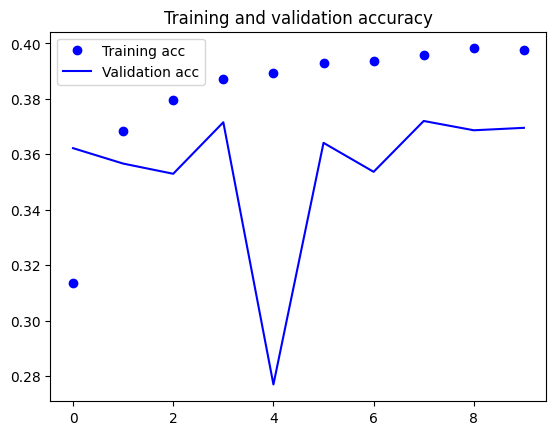

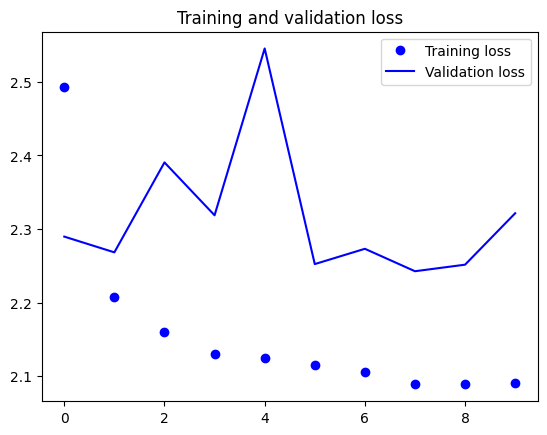

In [13]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [14]:
# Save the Model
model1.save('text_model_1.h5')

### Model 2

In [15]:
model2 = Sequential()
model2.add(LSTM(32, input_shape=(SEQUENCE_LENGTH, len(chars))))
model2.add(Dense(len(chars), activation='softmax'))

model2.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=['acc'])
history = model2.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
1062/1062 [==============================] - 15s 13ms/step - loss: 2.8125 - acc: 0.2236 - val_loss: 2.4843 - val_acc: 0.3046
Epoch 2/10
1062/1062 [==============================] - 13s 12ms/step - loss: 2.3776 - acc: 0.3235 - val_loss: 2.2776 - val_acc: 0.3463
Epoch 3/10
1062/1062 [==============================] - 13s 12ms/step - loss: 2.2350 - acc: 0.3579 - val_loss: 2.1688 - val_acc: 0.3752
Epoch 4/10
1062/1062 [==============================] - 13s 12ms/step - loss: 2.1458 - acc: 0.3827 - val_loss: 2.1010 - val_acc: 0.3960
Epoch 5/10
1062/1062 [==============================] - 13s 12ms/step - loss: 2.0787 - acc: 0.3994 - val_loss: 2.0452 - val_acc: 0.4111
Epoch 6/10
1062/1062 [==============================] - 13s 12ms/step - loss: 2.0284 - acc: 0.4119 - val_loss: 2.0078 - val_acc: 0.4170
Epoch 7/10
1062/1062 [==============================] - 13s 12ms/step - loss: 1.9897 - acc: 0.4221 - val_loss: 1.9732 - val_acc: 0.4302
Epoch 8/10
1062/1062 [==========================

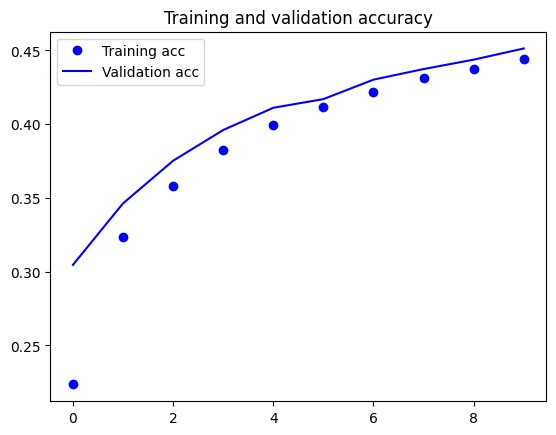

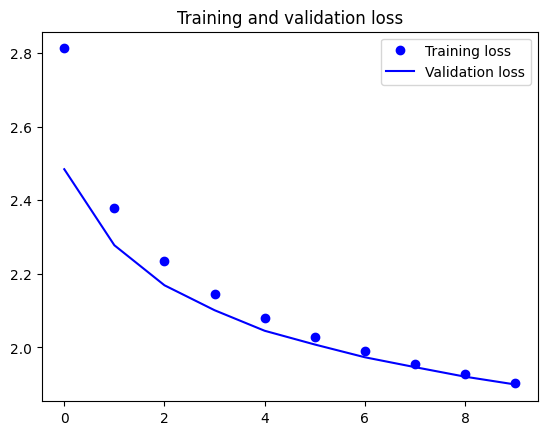

In [16]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [17]:
# Save the Model
model2.save('text_model_2.h5')

### Model 3

In [18]:
model3 = Sequential()
model3.add(GRU(32, input_shape=(SEQUENCE_LENGTH, len(chars))))
model3.add(Dense(len(chars), activation='softmax'))

model3.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=['acc'])
history = model3.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
1062/1062 [==============================] - 14s 12ms/step - loss: 2.6436 - acc: 0.2700 - val_loss: 2.3169 - val_acc: 0.3300
Epoch 2/10
1062/1062 [==============================] - 13s 12ms/step - loss: 2.2385 - acc: 0.3540 - val_loss: 2.1473 - val_acc: 0.3837
Epoch 3/10
1062/1062 [==============================] - 13s 13ms/step - loss: 2.1054 - acc: 0.3917 - val_loss: 2.0517 - val_acc: 0.4064
Epoch 4/10
1062/1062 [==============================] - 13s 12ms/step - loss: 2.0196 - acc: 0.4121 - val_loss: 1.9822 - val_acc: 0.4233
Epoch 5/10
1062/1062 [==============================] - 13s 12ms/step - loss: 1.9573 - acc: 0.4288 - val_loss: 1.9332 - val_acc: 0.4379
Epoch 6/10
1062/1062 [==============================] - 12s 12ms/step - loss: 1.9103 - acc: 0.4412 - val_loss: 1.8943 - val_acc: 0.4480
Epoch 7/10
1062/1062 [==============================] - 12s 12ms/step - loss: 1.8740 - acc: 0.4503 - val_loss: 1.8673 - val_acc: 0.4550
Epoch 8/10
1062/1062 [==========================

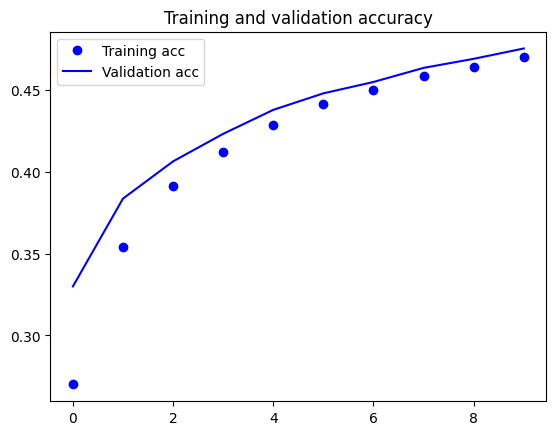

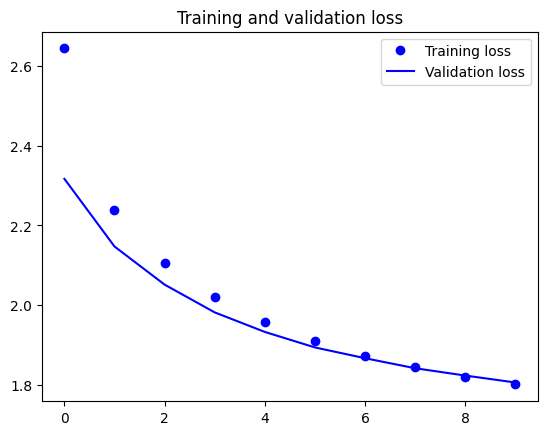

In [19]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
# Save the Model
model3.save('text_model_3.h5')

### Model 4

In [21]:
model4 = Sequential()
model4.add(GRU(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model4.add(Dense(len(chars), activation='softmax'))

model4.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(learning_rate=0.001), metrics=['acc'])
history = model4.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
1062/1062 [==============================] - 24s 21ms/step - loss: 2.3891 - acc: 0.3288 - val_loss: 2.0972 - val_acc: 0.3995
Epoch 2/10
1062/1062 [==============================] - 22s 20ms/step - loss: 1.9918 - acc: 0.4217 - val_loss: 1.8924 - val_acc: 0.4507
Epoch 3/10
1062/1062 [==============================] - 22s 20ms/step - loss: 1.8246 - acc: 0.4660 - val_loss: 1.7788 - val_acc: 0.4799
Epoch 4/10
1062/1062 [==============================] - 21s 20ms/step - loss: 1.7186 - acc: 0.4922 - val_loss: 1.7006 - val_acc: 0.4992
Epoch 5/10
1062/1062 [==============================] - 21s 20ms/step - loss: 1.6433 - acc: 0.5115 - val_loss: 1.6554 - val_acc: 0.5110
Epoch 6/10
1062/1062 [==============================] - 22s 20ms/step - loss: 1.5853 - acc: 0.5270 - val_loss: 1.6176 - val_acc: 0.5205
Epoch 7/10
1062/1062 [==============================] - 21s 20ms/step - loss: 1.5367 - acc: 0.5385 - val_loss: 1.5785 - val_acc: 0.5331
Epoch 8/10
1062/1062 [==========================

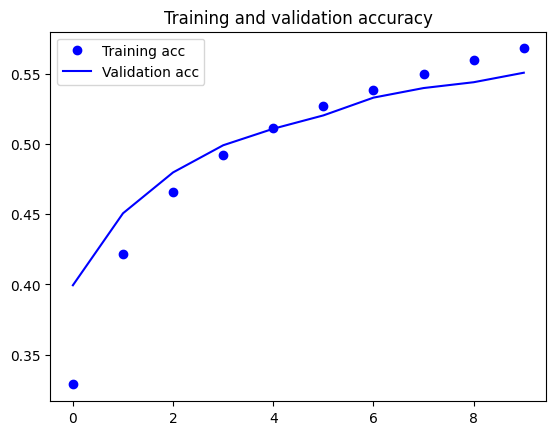

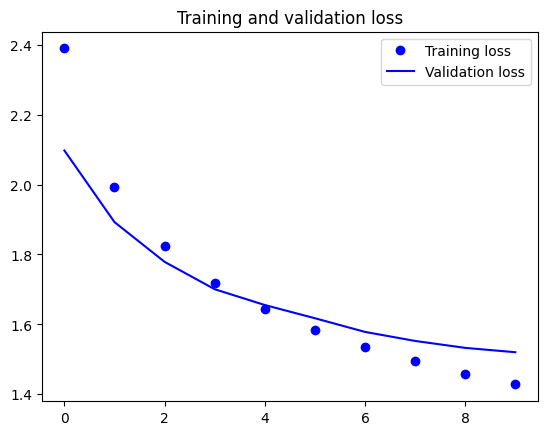

In [22]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
# Save the Model
model4.save('text_model_4.h5')

### Model 5

In [24]:
model5 = Sequential()
model5.add(LSTM(128, input_shape=(SEQUENCE_LENGTH, len(chars))))
model5.add(Dense(len(chars), activation='softmax'))

model5.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(learning_rate=0.001), metrics=['acc'])
history = model5.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
1062/1062 [==============================] - 27s 24ms/step - loss: 2.5356 - acc: 0.2924 - val_loss: 2.2272 - val_acc: 0.3728
Epoch 2/10
1062/1062 [==============================] - 25s 24ms/step - loss: 2.1228 - acc: 0.3930 - val_loss: 2.0164 - val_acc: 0.4159
Epoch 3/10
1062/1062 [==============================] - 26s 24ms/step - loss: 1.9419 - acc: 0.4335 - val_loss: 1.8803 - val_acc: 0.4500
Epoch 4/10
1062/1062 [==============================] - 25s 24ms/step - loss: 1.8297 - acc: 0.4618 - val_loss: 1.8098 - val_acc: 0.4647
Epoch 5/10
1062/1062 [==============================] - 25s 24ms/step - loss: 1.7487 - acc: 0.4835 - val_loss: 1.7428 - val_acc: 0.4880
Epoch 6/10
1062/1062 [==============================] - 25s 24ms/step - loss: 1.6846 - acc: 0.5019 - val_loss: 1.6913 - val_acc: 0.5038
Epoch 7/10
1062/1062 [==============================] - 25s 24ms/step - loss: 1.6320 - acc: 0.5162 - val_loss: 1.6569 - val_acc: 0.5148
Epoch 8/10
1062/1062 [==========================

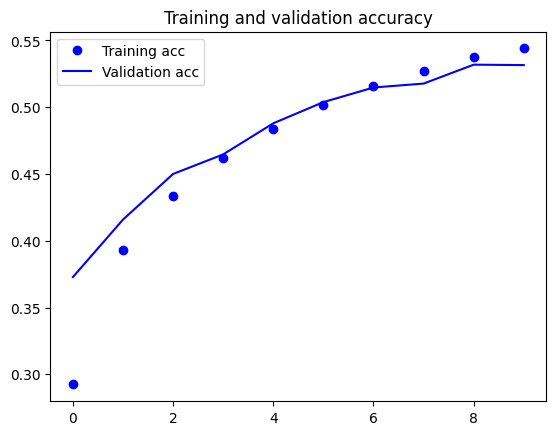

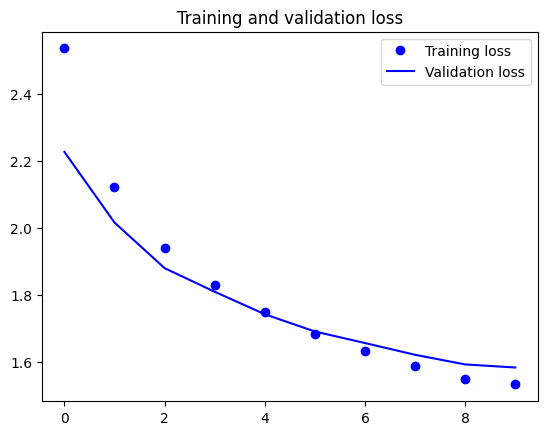

In [25]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
# Save the Model
model5.save('text_model_5.h5')

### Model 6

In [27]:
model6 = Sequential()
model6.add(GRU(128, input_shape=(SEQUENCE_LENGTH, len(chars)), return_sequences=True))
model6.add(GRU(128))
model6.add(Dense(len(chars), activation='softmax'))

model6.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(learning_rate=0.002), metrics=['acc'])
history = model6.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
1062/1062 [==============================] - 44s 38ms/step - loss: 2.0849 - acc: 0.3981 - val_loss: 1.7767 - val_acc: 0.4794
Epoch 2/10
1062/1062 [==============================] - 40s 38ms/step - loss: 1.6590 - acc: 0.5064 - val_loss: 1.5877 - val_acc: 0.5262
Epoch 3/10
1062/1062 [==============================] - 39s 37ms/step - loss: 1.5086 - acc: 0.5443 - val_loss: 1.5137 - val_acc: 0.5502
Epoch 4/10
1062/1062 [==============================] - 39s 37ms/step - loss: 1.4159 - acc: 0.5691 - val_loss: 1.4736 - val_acc: 0.5568
Epoch 5/10
1062/1062 [==============================] - 39s 37ms/step - loss: 1.3481 - acc: 0.5860 - val_loss: 1.4372 - val_acc: 0.5711
Epoch 6/10
1062/1062 [==============================] - 39s 37ms/step - loss: 1.2941 - acc: 0.6015 - val_loss: 1.4232 - val_acc: 0.5760
Epoch 7/10
1062/1062 [==============================] - 39s 37ms/step - loss: 1.2494 - acc: 0.6127 - val_loss: 1.4220 - val_acc: 0.5761
Epoch 8/10
1062/1062 [==========================

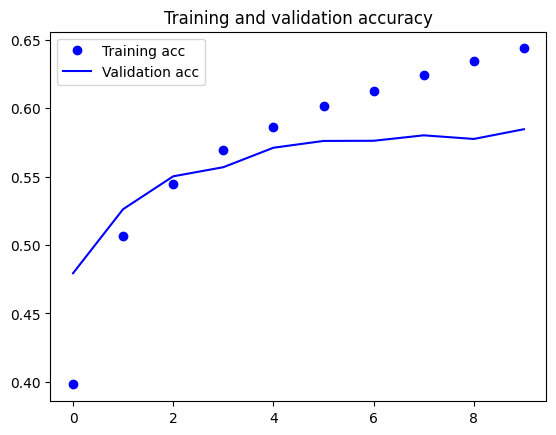

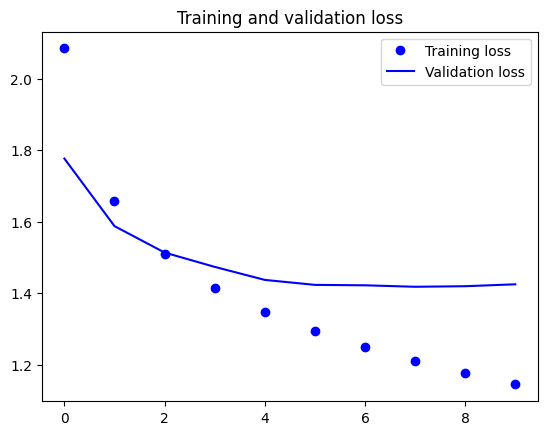

In [28]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [29]:
# Save the Model
model6.save('text_model_6.h5')

### Model 7

In [30]:
model7 = Sequential()
model7.add(GRU(256, input_shape=(SEQUENCE_LENGTH, len(chars)), return_sequences=True))
model7.add(Dropout(0.2))
model7.add(GRU(128))
model7.add(Dense(len(chars), activation='softmax'))

model7.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(learning_rate=0.003), metrics=['acc'])
history = model7.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
1062/1062 [==============================] - 76s 69ms/step - loss: 1.9768 - acc: 0.4250 - val_loss: 1.6602 - val_acc: 0.5033
Epoch 2/10
1062/1062 [==============================] - 73s 69ms/step - loss: 1.5876 - acc: 0.5228 - val_loss: 1.5185 - val_acc: 0.5415
Epoch 3/10
1062/1062 [==============================] - 73s 69ms/step - loss: 1.4649 - acc: 0.5546 - val_loss: 1.4661 - val_acc: 0.5600
Epoch 4/10
1062/1062 [==============================] - 73s 69ms/step - loss: 1.3983 - acc: 0.5736 - val_loss: 1.4340 - val_acc: 0.5676
Epoch 5/10
1062/1062 [==============================] - 76s 71ms/step - loss: 1.3548 - acc: 0.5846 - val_loss: 1.4189 - val_acc: 0.5776
Epoch 6/10
1062/1062 [==============================] - 76s 71ms/step - loss: 1.3182 - acc: 0.5931 - val_loss: 1.4082 - val_acc: 0.5776
Epoch 7/10
1062/1062 [==============================] - 76s 71ms/step - loss: 1.2972 - acc: 0.5994 - val_loss: 1.4082 - val_acc: 0.5814
Epoch 8/10
1062/1062 [==========================

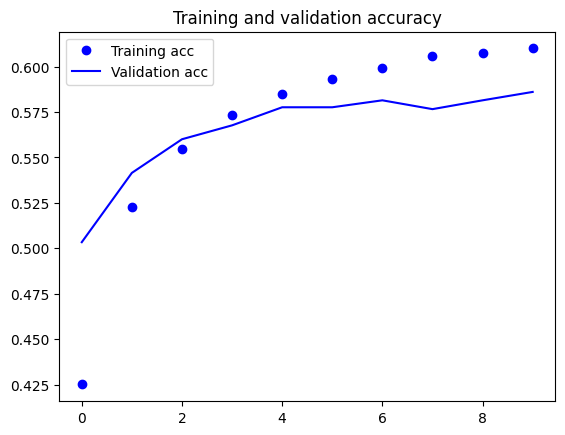

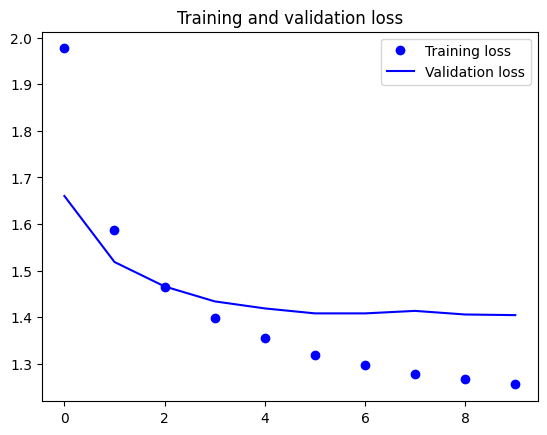

In [31]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [32]:
# Save the Model
model7.save('text_model_7.h5')

### Model 8

In [33]:
model8 = Sequential()
model8.add(GRU(256, input_shape=(SEQUENCE_LENGTH, len(chars)), return_sequences=True))
model8.add(Dropout(0.2))
model8.add(GRU(160))
model8.add(Dropout(0.2))
model8.add(Dense(len(chars), activation='softmax',kernel_regularizer=regularizers.l2(0.01)))

model8.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(learning_rate=0.004), metrics=['acc'])
history = model8.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
1062/1062 [==============================] - 82s 75ms/step - loss: 2.3029 - acc: 0.3843 - val_loss: 1.9434 - val_acc: 0.4790
Epoch 2/10
1062/1062 [==============================] - 79s 74ms/step - loss: 1.9179 - acc: 0.4870 - val_loss: 1.8102 - val_acc: 0.5172
Epoch 3/10
1062/1062 [==============================] - 79s 74ms/step - loss: 1.8288 - acc: 0.5112 - val_loss: 1.7681 - val_acc: 0.5261
Epoch 4/10
1062/1062 [==============================] - 79s 75ms/step - loss: 1.7841 - acc: 0.5260 - val_loss: 1.7478 - val_acc: 0.5388
Epoch 5/10
1062/1062 [==============================] - 79s 74ms/step - loss: 1.7569 - acc: 0.5332 - val_loss: 1.7221 - val_acc: 0.5442
Epoch 6/10
1062/1062 [==============================] - 79s 74ms/step - loss: 1.7388 - acc: 0.5384 - val_loss: 1.7036 - val_acc: 0.5452
Epoch 7/10
1062/1062 [==============================] - 79s 74ms/step - loss: 1.7292 - acc: 0.5421 - val_loss: 1.6938 - val_acc: 0.5505
Epoch 8/10
1062/1062 [==========================

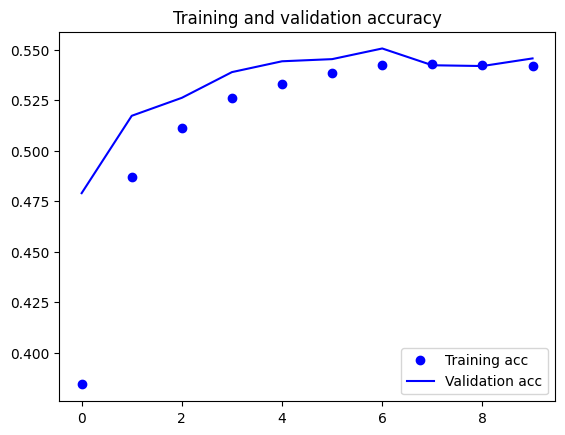

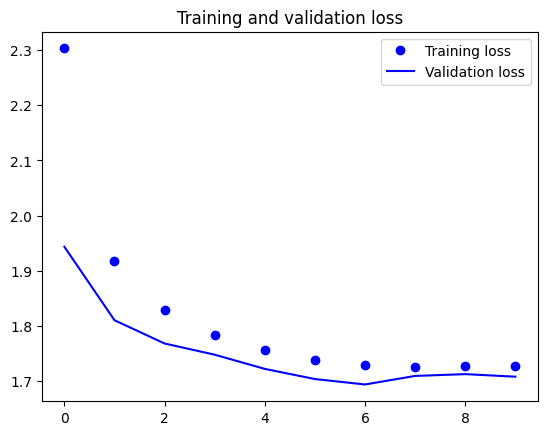

In [34]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [35]:
# Save the Model
model8.save('text_model_8.h5')

### Model 9

In [36]:
model9 = Sequential()
model9.add(GRU(256, input_shape=(SEQUENCE_LENGTH, len(chars)), return_sequences=True))
model9.add(Dropout(0.2))
model9.add(GRU(128))
model9.add(Dense(len(chars), activation='softmax',kernel_regularizer=regularizers.l2(0.01)))

model9.compile(loss="categorical_crossentropy", optimizer=optimizers.RMSprop(learning_rate=0.004), metrics=['acc'])
history = model9.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
1062/1062 [==============================] - 78s 71ms/step - loss: 2.2797 - acc: 0.3927 - val_loss: 1.9451 - val_acc: 0.4752
Epoch 2/10
1062/1062 [==============================] - 76s 71ms/step - loss: 1.8885 - acc: 0.4973 - val_loss: 1.8150 - val_acc: 0.5226
Epoch 3/10
1062/1062 [==============================] - 75s 71ms/step - loss: 1.8012 - acc: 0.5221 - val_loss: 1.7692 - val_acc: 0.5333
Epoch 4/10
1062/1062 [==============================] - 75s 71ms/step - loss: 1.7557 - acc: 0.5357 - val_loss: 1.7418 - val_acc: 0.5381
Epoch 5/10
1062/1062 [==============================] - 75s 71ms/step - loss: 1.7327 - acc: 0.5429 - val_loss: 1.7194 - val_acc: 0.5490
Epoch 6/10
1062/1062 [==============================] - 76s 71ms/step - loss: 1.7152 - acc: 0.5484 - val_loss: 1.7170 - val_acc: 0.5479
Epoch 7/10
1062/1062 [==============================] - 76s 71ms/step - loss: 1.7052 - acc: 0.5517 - val_loss: 1.7102 - val_acc: 0.5522
Epoch 8/10
1062/1062 [==========================

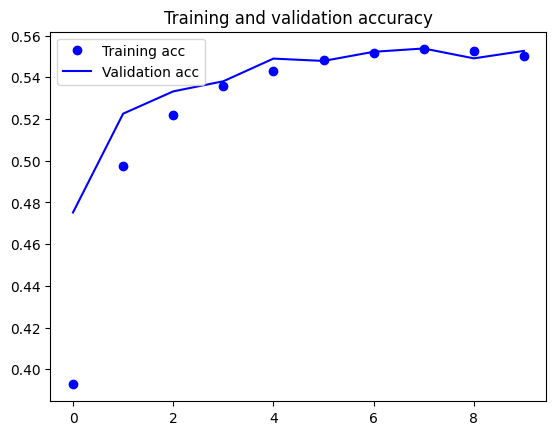

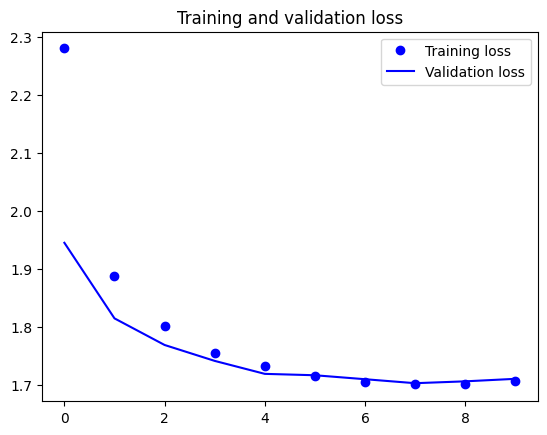

In [37]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
# Save the Model
model9.save('text_model_9.h5')

### Model 10

In [39]:
model10 = Sequential()
model10.add(GRU(512, input_shape=(SEQUENCE_LENGTH, len(chars)), return_sequences=True))
model10.add(Dropout(0.3))
model10.add(GRU(256))
model10.add(Dense(len(chars), activation='softmax', kernel_regularizer=regularizers.l2(0.005)))

model10.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=0.001), metrics=['acc'])
history = model10.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
1062/1062 [==============================] - 165s 153ms/step - loss: 2.2763 - acc: 0.3831 - val_loss: 1.8901 - val_acc: 0.4785
Epoch 2/10
1062/1062 [==============================] - 162s 153ms/step - loss: 1.7866 - acc: 0.5010 - val_loss: 1.6858 - val_acc: 0.5301
Epoch 3/10
1062/1062 [==============================] - 162s 153ms/step - loss: 1.6371 - acc: 0.5416 - val_loss: 1.6003 - val_acc: 0.5521
Epoch 4/10
1062/1062 [==============================] - 162s 152ms/step - loss: 1.5478 - acc: 0.5660 - val_loss: 1.5464 - val_acc: 0.5680
Epoch 5/10
1062/1062 [==============================] - 162s 152ms/step - loss: 1.4818 - acc: 0.5858 - val_loss: 1.5131 - val_acc: 0.5805
Epoch 6/10
1062/1062 [==============================] - 162s 152ms/step - loss: 1.4306 - acc: 0.6026 - val_loss: 1.4918 - val_acc: 0.5859
Epoch 7/10
1062/1062 [==============================] - 162s 152ms/step - loss: 1.3859 - acc: 0.6144 - val_loss: 1.4816 - val_acc: 0.5889
Epoch 8/10
1062/1062 [============

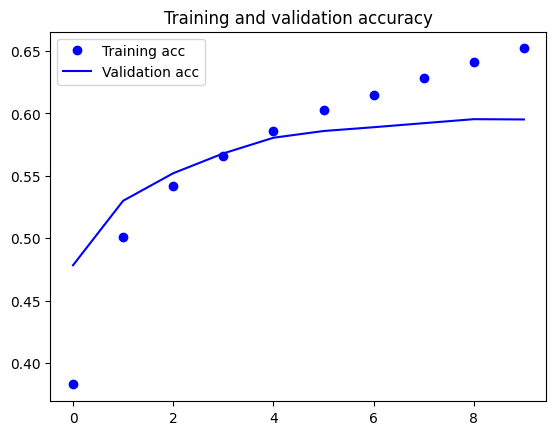

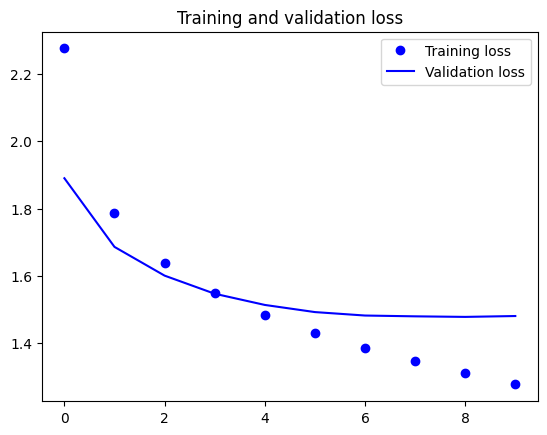

In [40]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [41]:
# Save the Model
model10.save('text_model_10.h5')

### Model 11

In [42]:
model11 = Sequential()
model11.add(GRU(512, input_shape=(SEQUENCE_LENGTH, len(chars)), return_sequences=True))
model11.add(Dropout(0.3))
model11.add(GRU(256))
model11.add(Dense(len(chars), activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model11.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=0.001), metrics=['acc'])
history = model11.fit(X_train, y_train, epochs=10, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/10
1062/1062 [==============================] - 172s 160ms/step - loss: 2.3646 - acc: 0.3735 - val_loss: 1.9844 - val_acc: 0.4598
Epoch 2/10
1062/1062 [==============================] - 170s 161ms/step - loss: 1.8749 - acc: 0.4891 - val_loss: 1.7749 - val_acc: 0.5125
Epoch 3/10
1062/1062 [==============================] - 174s 163ms/step - loss: 1.7249 - acc: 0.5292 - val_loss: 1.6815 - val_acc: 0.5397
Epoch 4/10
1062/1062 [==============================] - 173s 163ms/step - loss: 1.6384 - acc: 0.5550 - val_loss: 1.6300 - val_acc: 0.5581
Epoch 5/10
1062/1062 [==============================] - 169s 159ms/step - loss: 1.5748 - acc: 0.5736 - val_loss: 1.5960 - val_acc: 0.5684
Epoch 6/10
1062/1062 [==============================] - 173s 163ms/step - loss: 1.5242 - acc: 0.5889 - val_loss: 1.5628 - val_acc: 0.5785
Epoch 7/10
1062/1062 [==============================] - 173s 163ms/step - loss: 1.4817 - acc: 0.6018 - val_loss: 1.5506 - val_acc: 0.5844
Epoch 8/10
1062/1062 [============

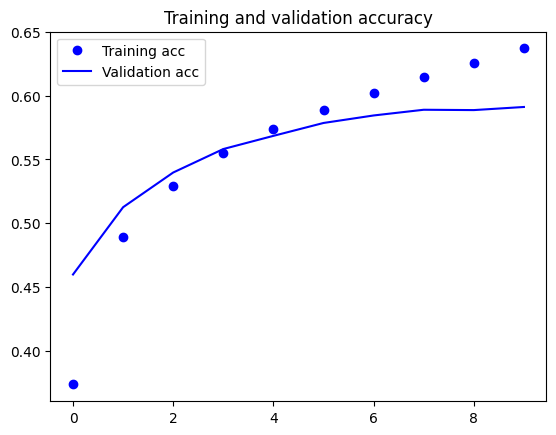

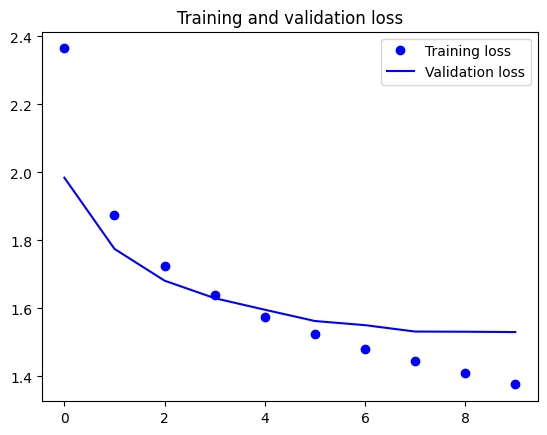

In [43]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [44]:
# Save the Model
model11.save('text_model_11.h5')

### Model 12

In [45]:
model12 = Sequential()
model12.add(GRU(512, input_shape=(SEQUENCE_LENGTH, len(chars)), return_sequences=True))
model12.add(Dropout(0.35))
model12.add(GRU(256))
model12.add(Dense(len(chars), activation='softmax', kernel_regularizer=regularizers.l2(0.01)))

model12.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(learning_rate=0.0015), metrics=['acc'])
history = model12.fit(X_train, y_train, epochs=20, batch_size=128, validation_data=(X_test, y_test))

Epoch 1/20
1062/1062 [==============================] - 176s 164ms/step - loss: 2.2777 - acc: 0.3914 - val_loss: 1.8854 - val_acc: 0.4880
Epoch 2/20
1062/1062 [==============================] - 175s 165ms/step - loss: 1.8122 - acc: 0.5053 - val_loss: 1.7212 - val_acc: 0.5325
Epoch 3/20
1062/1062 [==============================] - 174s 164ms/step - loss: 1.6802 - acc: 0.5432 - val_loss: 1.6363 - val_acc: 0.5542
Epoch 4/20
1062/1062 [==============================] - 174s 164ms/step - loss: 1.6030 - acc: 0.5636 - val_loss: 1.6028 - val_acc: 0.5639
Epoch 5/20
1062/1062 [==============================] - 172s 162ms/step - loss: 1.5486 - acc: 0.5799 - val_loss: 1.5682 - val_acc: 0.5748
Epoch 6/20
1062/1062 [==============================] - 171s 161ms/step - loss: 1.5063 - acc: 0.5926 - val_loss: 1.5565 - val_acc: 0.5763
Epoch 7/20
1062/1062 [==============================] - 171s 161ms/step - loss: 1.4689 - acc: 0.6039 - val_loss: 1.5310 - val_acc: 0.5867
Epoch 8/20
1062/1062 [============

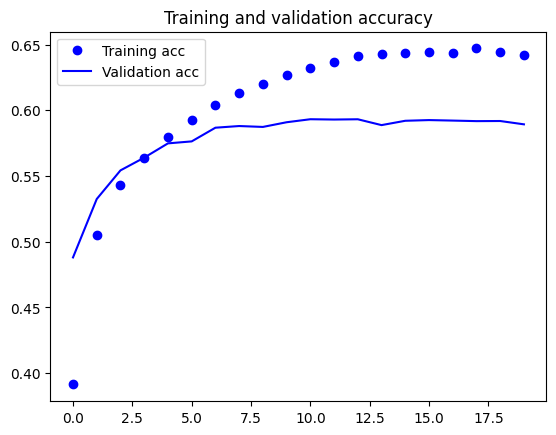

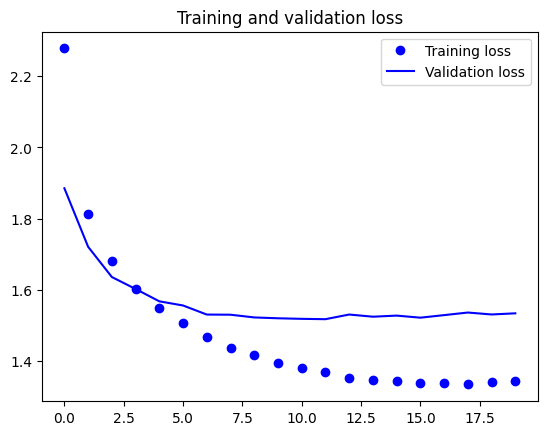

In [46]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
# Save the Model
model12.save('text_model_12.h5')

In [49]:
#Generating text
model_list = [model1,model2,model3,model4,model5,model6,model7,model8,model9,model10,model11,model12]

j=1
for i in model_list:
    print("Model ",j, ": \n")
    start_index = np.random.randint(0, len(text) - SEQUENCE_LENGTH - 1)
    generated_text = text[start_index: start_index + SEQUENCE_LENGTH]
    print('--- Generating with seed: "' + generated_text + '"')
    j+=1

    for temperature in [0.2, 0.5, 1.0, 1.2]:
        generate_text(i, SEQUENCE_LENGTH, generated_text, temperature=temperature)

Model  1 : 

--- Generating with seed: "... it’s not as though i really wanted to join. ... thought "
------ temperature: 0.2
... it’s not as though i really wanted to join. ... thought was ware dor ard the the sed he rouseed to the se the sore to the sed he roond the the se the seare s on the ero the the se tore he tor he ro the sare the sead he the eas the seree ser and the ere tor the sare the she sere the sead he round the saro he ro the the sere the the s oo the the se the ro the roo se the sere tor he the ser and ron the the sere the se the roo he red herred the sere har in
Perplexity: 2.7578002880319836

------ temperature: 0.5
... it’s not as though i really wanted to join. ... thought so and en thes ardithe hide sobe dore he the sarey her anded ore arat sould ther and he tored ha reas are harr hed do the he red he rea eed ro he seas in the he red an sound to the he taid harred harred lo the sore ho here s oothe sard to the rand sto thin or ared han s oo the her the harre the s

lle longbottom. “unbelievablel” beamed seamus. “cool,” said ron inbaracame and startart sage from his niwn of the wall be onim as the draw?rrad jack, no mandle, and saiorfore last feld the. his seluss hem trreat, someunted a madsk over he wrots grormegs dien hagrid han shideled at she sarqying beaoce. “too. wh’t fouw. ““a past strrod in from, ” yang hemilustee ? !h“no’s lafl al-b old cded!” said mr ottily, harry had than all fer was maka dracbnance. he hom
Perplexity: 6.977468397566164

------ temperature: 1.2
lle longbottom. “unbelievablel” beamed seamus. “cool,” said shrood, showm. “staribred a,, sibpar my builead ible you doo’s been but uply noo,. iedlac’gry, whating rach you caes they. “somwion, dat”  their voely. ” “and mles— and harcha-lum“eries.!de, thaghat, uoted the brogid. “shale a deads. fell xane”” longs. and —n a gearderich.us colstek laver and a same a wialigwpreke head.. sork ’pt ?k hoich. grdamed, “noothrofs, blean, is hones, bethere ond a leap— 
Perplexity: 9.444377743

## Step 3 – Use the developed Model to generate the characters / sentences

In [50]:
best_model = model10

In [51]:
# Get user input and generate text based on the input
user_input = input("Enter your starting text: ").lower()

Enter your starting text: George was nowhere to be found when a student asked him a question


In [52]:
user_input = decontracted(user_input)
user_input = re.sub("[()*%/:;\\|•\n]", "", user_input)

In [53]:
# Use the Best Model to generate 400 characters
print('--- Generating with seed: "' + user_input + '"')
for temperature in [0.2, 0.5, 1.0, 1.2]:
    generate_text_based_on_input(best_model, SEQUENCE_LENGTH,input_text=user_input, temperature=temperature)

--- Generating with seed: "george was nowhere to be found when a student asked him a question"
------ temperature: 0.2
 was nowhere to be found when a student asked him a question, and the distracted the dark art looked at his things and the distracted the face that the disturned students to the forest and the disturned for the first of the disturned for the train and started to the door and the distracted the destrace the carest students and the disturned still harry and ron and hermione as they were still to the door and the distracted the door and started to the distort
Perplexity: 2.0566325201954783

------ temperature: 0.5
 was nowhere to be found when a student asked him a question, and the car in the floor, still thing the four potions to the all the troing a pace would have the dark face of the distrat of the letter of stopped at the slowed around the silence dagged around the fast that the train and the for the fable as they taken to the poof his turning harry gathered the fir